# 1. Introduction
This Notebook follows three main parts:
- The data preparation
- The CNN modeling and evaluation
- The results prediction and submission

这是一个 5 层顺序卷积神经网络，用于在 MNIST 数据集上训练的数字识别。 我选择使用非常直观的 keras API（Tensorflow 后端）来构建它。 首先，我将准备数据（手写数字图像），然后我将专注于 CNN 建模和评估。 

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import tensorflow as tf 
config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
%matplotlib inline

## 2. Data preparation
### 2.1 Load data

In [2]:
# Load the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
train.describe(include='all')

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


c:\users\86137\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

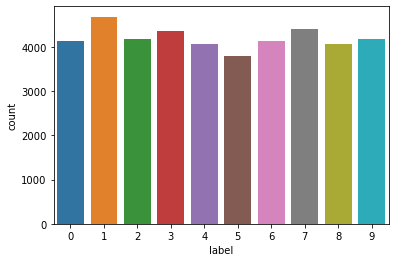

In [6]:
Y_train = train['label'] 

X_train = train.drop('label',axis=1)

sns.countplot(Y_train)
Y_train.value_counts()

We have similar counts for the 10 digits.

我们差不多有十个标签，数目差不多，就是0-9，我们的数字标签

### 2.2 Check for null and missing values 缺失值处理

In [7]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

There is no missing values in the train and test dataset. So we can safely go ahead

训练和测试数据集中没有缺失值。 所以我们可以放心地继续前进

### 2.3 Normalization 标准化处理

我们实现灰度归一化以减少光照差异的影响。
此外，CNN 在 [0..1] 数据上的收敛速度比在 [0..255] 上更快

In [9]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

## 2.4 Reshape

In [10]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [11]:
X_train.shape

(42000, 28, 28, 1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

训练和测试图像 (28px x 28px) 已作为 784 个值的一维向量存入 pandas.Dataframe。 我们将所有数据重塑为 28x28x1 3D 矩阵。

Keras 最后需要一个与通道相对应的额外维度。 MNIST 图像是灰度化的，所以它只使用一个通道。 对于 RGB 图像，有 3 个通道，我们会将 784 像素的向量重塑为 28x28x3 的 3D 矩阵。

## 2.5 Label encoding

In [12]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

标签是从 0 到 9 的 10 位数字。我们需要将标签编码为一个one-hot 向量（例如：2 -> [0,0,1,0,0,0,0,0,0,0]）

## 2.6 Split training and valdiation set

In [13]:
# Set the random seed
random_seed = 2

In [14]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.

我选择将训练集分成两部分：一小部分 (10%) 成为评估模型的验证集，其余 (90%) 用于训练模型。

由于我们有 42 000 张平衡标签的训练图像（参见 2.1 加载数据），训练集的随机拆分不会导致某些标签在验证集中过度表示。 小心一些不平衡的数据集，简单的随机拆分可能会导致验证过程中的评估不准确。

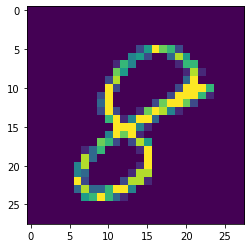

In [15]:
plt.imshow(X_train[0][:,:,0])


## 3.CNN

我使用了 Keras Sequential API，您只需从输入开始，一次添加一层。

第一个是卷积（Conv2D）层。它就像一组可学习的过滤器。我选择为前两个 conv2D 层设置 32 个过滤器，为最后两个层设置 64 个过滤器。每个过滤器使用内核过滤器转换图像的一部分（由内核大小定义）。内核滤波器矩阵应用于整个图像。过滤器可以看作是图像的一种变换。

CNN 可以从这些转换后的图像（特征图）中分离出处处有用的特征。

CNN 中的第二个重要层是池化 (MaxPool2D) 层。该层仅充当下采样滤波器。它查看 2 个相邻像素并选择最大值。这些用于降低计算成本，并在一定程度上减少过拟合。我们必须选择池化大小（即每次池化的区域大小），池化维度越高，下采样越重要。

结合卷积层和池化层，CNN 能够结合局部特征并学习图像的更多全局特征。

Dropout 是一种正则化方法，对于每个训练样本，层中一定比例的节点被随机忽略（将它们的权重设置为零）。这会随机丢弃网络的一部分，并强制网络以分布式方式学习特征。这种技术还提高了泛化能力并减少了过拟合。

'relu' 是激活函数 max(0,x)。激活函数用于为网络添加非线性。

Flatten 层用于将最终的特征图转换为一个单一的一维向量。 需要此展平步骤，以便您可以在一些卷积/最大池层之后使用完全连接的层。 它结合了先前卷积层的所有找到的局部特征。

最后，我使用了两个完全连接（密集）层中的特征，这只是人工神经网络（ANN）分类器。 在最后一层 (Dense(10,activation="softmax")) 中，每个类别的概率的净输出分布。

In [16]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation = "softmax"))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

In [36]:
# model = Sequential()
# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu', input_shape = (28,28,1)))
# model.add(BatchNormalization())
# model.add(Conv2D(filters = 64, kernel_size = (3,3), padding= 'Same',
#                 activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Conv2D(filters= 128, kernel_size=(3,3),padding="Same",
#                 activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters= 128, kernel_size=(3,3),padding="Same",
#                 activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Dropout(0.25))

# model.add(Conv2D(filters= 256, kernel_size=(3,3),padding="Same",
#                 activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters= 256, kernel_size=(3,3),padding="Same",
#                 activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters= 512, kernel_size=(3,3),padding="Same",
#                 activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters= 512, kernel_size=(3,3),padding="Same",
#                 activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(10,activation='softmax'))
# model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_21 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 128)      

## 3.2 Set the optimizer and annealer 设置优化器和退火器

一旦我们的层被添加到模型中，我们需要设置一个评分函数、一个损失函数和一个优化算法。

我们定义了损失函数来衡量我们的模型在具有已知标签的图像上的表现有多差。它是观察到的标签和预测的标签之间的错误率。我们使用称为“categorical_crossentropy”的分类分类（> 2 个类别）的特定形式。

最重要的功能是优化器。该函数将迭代地改进参数（过滤核值、神经元的权重和偏差......）以最小化损失。

我选择了 RMSprop（带有默认值），它是一个非常有效的优化器。 RMSProp 更新以非常简单的方式调整 Adagrad 方法，以尝试降低其激进的、单调递减的学习率。我们也可以使用随机梯度下降 ('SGD') 优化器，但它比 RMSprop 慢。

度量函数“准确度”用于评估我们模型的性能。该度量函数类似于损失函数，不同之处在于在训练模型时不使用度量​​评估的结果（仅用于评估）。

In [37]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [38]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

为了使优化器收敛得更快并且最接近损失函数的全局最小值，我使用了学习率（LR）的退火方法。

LR 是优化器遍历“损失情况”的步骤。 LR越高，步长越大，收敛越快。 然而，高 LR 的采样非常差，优化器可能会陷入局部最小值。

最好在训练期间降低学习率，以有效地达到损失函数的全局最小值。

为了保持具有高 LR 的快速计算时间的优势，我根据是否有必要（当精度未提高时）每 X 步（时期）动态地减少 LR。

使用 Keras.callbacks 的 ReduceLROnPlateau 函数，如果 3 个 epoch 后精度没有提高，我选择将 LR 减少一半。 

In [39]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [40]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 128

## 3.3 Data augmentation

为了避免过拟合问题，我们需要人为地扩展我们的手写数字数据集。我们可以使您现有的数据集更大。这个想法是通过小的转换来改变训练数据，以重现有人写数字时发生的变化。

比如数字不居中 比例不一样（有的写大/小数字） 图像旋转...

以改变数组表示同时保持标签不变的方式改变训练数据的方法被称为数据增强技术。人们使用的一些流行的增强是灰度、水平翻转、垂直翻转、随机裁剪、颜色抖动、平移、旋转等等。

通过对我们的训练数据应用这些转换中的几个，我们可以轻松地将训练示例的数量增加一倍或三倍，并创建一个非常强大的模型。

In [41]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

对于数据增强，我选择：
- 将一些训练图像随机旋转 10 度
- 将一些训练图像随机放大 10%
- 将图像水平随机移动 10% 的宽度
- 将图像垂直随机移动 10% 的高度

我没有应用vertical_flip 或horizontal_flip，因为它可能导致错误分类对称数，例如6 和9。
一旦我们的模型准备就绪，我们就会拟合训练数据集。

In [42]:
# # 如果有GPU 利用GPU
# import tensorflow as tf 
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.6
# # config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)

In [50]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 100, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/100
295/295 [==============================] - 39s 131ms/step - loss: 0.0081 - accuracy: 0.9976 - val_loss: 0.0340 - val_accuracy: 0.9938
Epoch 2/100
  1/295 [..............................] - ETA: 37s - loss: 1.9227e-04 - accuracy: 1.0000

c:\users\86137\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


295/295 [==============================] - 39s 132ms/step - loss: 0.0090 - accuracy: 0.9974 - val_loss: 0.0252 - val_accuracy: 0.9957
Epoch 3/100
295/295 [==============================] - 39s 132ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0310 - val_accuracy: 0.9955
Epoch 4/100
295/295 [==============================] - 39s 132ms/step - loss: 0.0077 - accuracy: 0.9979 - val_loss: 0.0299 - val_accuracy: 0.9948
Epoch 5/100
295/295 [==============================] - 39s 133ms/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.0286 - val_accuracy: 0.9952
Epoch 6/100
295/295 [==============================] - 40s 135ms/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.0298 - val_accuracy: 0.9955
Epoch 7/100
295/295 [==============================] - 39s 132ms/step - loss: 0.0074 - accuracy: 0.9982 - val_loss: 0.0316 - val_accuracy: 0.9950
Epoch 8/100
295/295 [==============================] - 39s 133ms/step - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.0317 - val_accurac

Epoch 58/100
295/295 [==============================] - 40s 136ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0493 - val_accuracy: 0.9948
Epoch 59/100
295/295 [==============================] - 40s 135ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0569 - val_accuracy: 0.9936
Epoch 60/100
295/295 [==============================] - 40s 135ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0506 - val_accuracy: 0.9955
Epoch 61/100
295/295 [==============================] - 40s 135ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0389 - val_accuracy: 0.9955
Epoch 62/100
295/295 [==============================] - 40s 135ms/step - loss: 0.0063 - accuracy: 0.9985 - val_loss: 0.0521 - val_accuracy: 0.9948
Epoch 63/100
295/295 [==============================] - 41s 139ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 0.0425 - val_accuracy: 0.9950
Epoch 64/100
295/295 [==============================] - 40s 136ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0

# 4. Evaluate the model
## 4.1 Training and validation curves

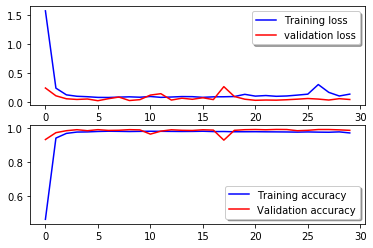

In [26]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

代码用于绘制训练和验证的损失和准确度曲线

在训练过程中，验证准确率几乎每次都高于训练准确率。 这意味着我们的模型不会过拟合训练集。

## 4.2 Confusion matrix 混淆矩阵
混淆矩阵对于查看模型缺点非常有帮助

我绘制了验证结果的混淆矩阵

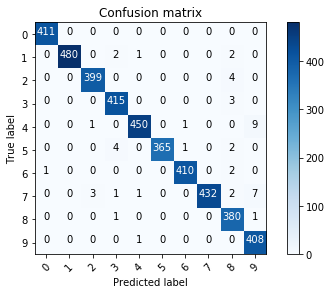

In [27]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

在这里我们可以看到，考虑到验证集的大小（4 200 张图像），我们的 CNN 在所有数字上都表现得非常好，几乎没有错误。

然而，我们的 CNN 似乎对 4 位数字有一些小问题，嘿嘿被误分类为 9。有时在曲线平滑时很难捕捉 4 和 9 之间的差异。

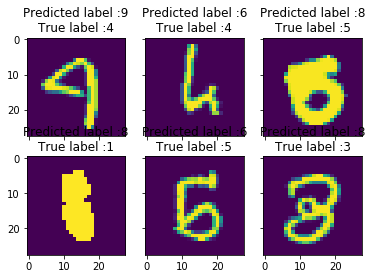

In [28]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1


# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

最重要的错误也是最有趣的。

对于这六个案例，该模型并不可笑。 其中一些错误也可能是人类造成的，尤其是对于非常接近 4 的 9。最后一个 9 也非常具有误导性，对我来说似乎是 0

# 5. Prediction and submition
## 5.1 Predict and Submit results

In [51]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [52]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

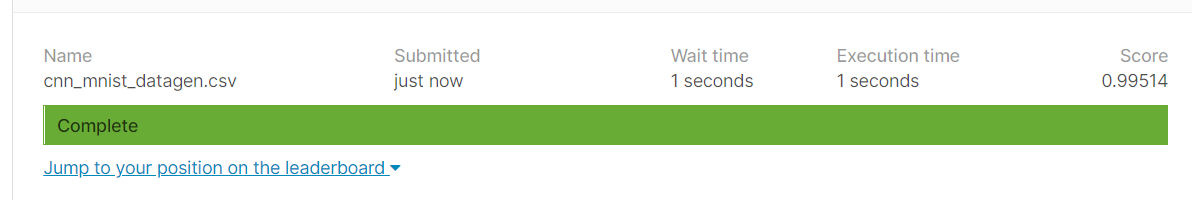